<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Check-out-the-data" data-toc-modified-id="Check-out-the-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Check out the data</a></span></li><li><span><a href="#a)-posterior-speed" data-toc-modified-id="a)-posterior-speed-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>a) posterior speed</a></span></li><li><span><a href="#b)-confidence-intervals" data-toc-modified-id="b)-confidence-intervals-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>b) confidence intervals</a></span></li><li><span><a href="#c)-same-speed" data-toc-modified-id="c)-same-speed-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>c) same speed</a></span></li><li><span><a href="#d)-reduced-data-set" data-toc-modified-id="d)-reduced-data-set-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>d) reduced data set</a></span></li></ul></div>

In [ ]:
import pandas
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pymc3 as pm
import arviz as az

### Check out the data

Load in data from location_data_hw8_2022.csv.

Since no units are given, I'm assuming position is measured in meters and time is measured in seconds.

In [2]:
fname = 'location_data_hw8_2022.csv'
data = pandas.read_csv(fname)

Visualize the data:

Text(0, 0.5, 'y position (m)')

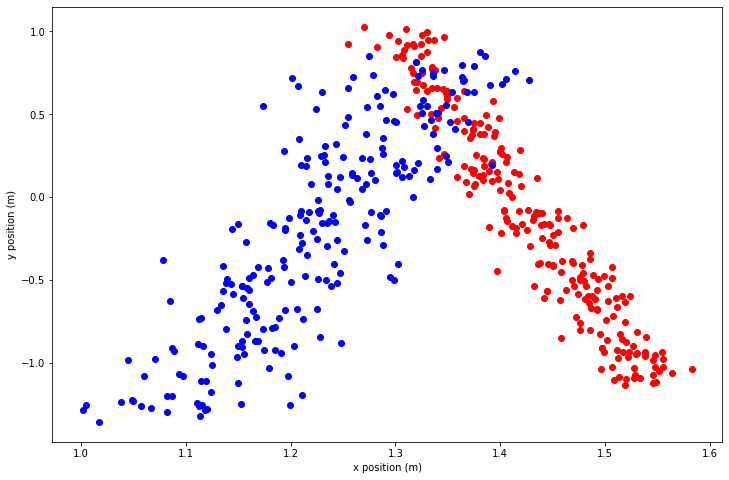

In [3]:
# plot the x, y position
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()

ax.scatter(data["red_pos_X"], data["red_pos_Y"], c="r")
ax.scatter(data["blue_pos_X"], data["blue_pos_Y"], c="b")
ax.set_xlabel("x position (m)")
ax.set_ylabel("y position (m)")

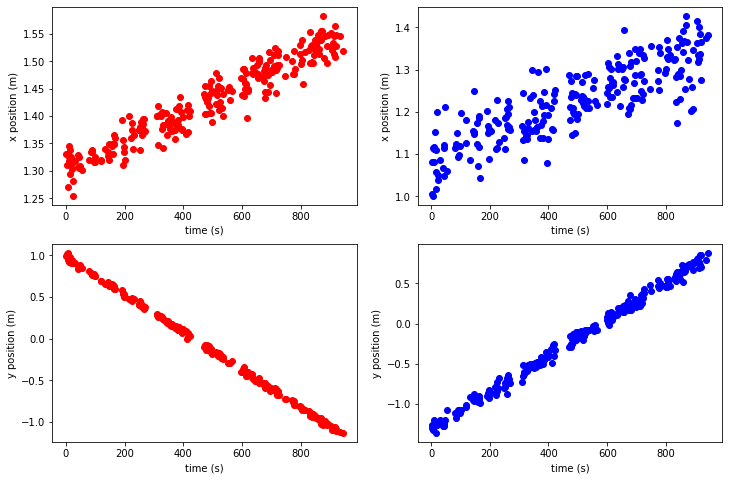

In [180]:
# plot x and y vs t
fig = plt.figure(figsize=(12, 8))

ax_rx = fig.add_subplot(2, 2, 1)
ax_rx.scatter(data["t"], data["red_pos_X"], c="r")
ax_rx.set_xlabel("time (s)")
ax_rx.set_ylabel("x position (m)")

ax_ry = fig.add_subplot(2, 2, 3)
ax_ry.scatter(data["t"], data["red_pos_Y"], c="r")
ax_ry.set_xlabel("time (s)")
ax_ry.set_ylabel("y position (m)")

ax_bx = fig.add_subplot(2, 2, 2)
ax_bx.scatter(data["t"], data["blue_pos_X"], c="b")
ax_bx.set_xlabel("time (s)")
ax_bx.set_ylabel("x position (m)")

ax_by = fig.add_subplot(2, 2, 4)
ax_by.scatter(data["t"], data["blue_pos_Y"], c="b")
ax_by.set_xlabel("time (s)")
ax_by.set_ylabel("y position (m)")

all_ax = [ax_rx, ax_ry, ax_bx, ax_by]
for ax in all_ax:
    ax.set_xlabel("time (s)")

### a) posterior speed

"Assume both objects move at a fixed speed/direction, and assume that there is a fixed measurement error (ie., the observed location in x,y is the true location plus some i.i.d. Gaussian random noise at time t)."

Let's think about the x component of the red object first.

The observed x location at each time x(t) is the sum of (1) velocity in the x direction V_x * time, (2) constant offset in the x direction c_x, and (3) normally distributed errors with mean 0 and variance sd2_x:

    x(t) = V_x * t + c_x + e(0, sd2_x)

- x(t) and t are observed. 

- V_x, c_x, and sd2_x are fit parameters. To start, assume these all have uniform (or uninformative) priors; get reasonable ranges from the data?

- MCMC works better on zscored data; doesn't converge if I use raw x(t)

In [236]:
# 1: pull out observed time vector

t = np.array(data["t"])

In [237]:
# 2: zscore observed x location of red component

red_x = np.array(data["red_pos_X"])

red_x_mu = red_x.mean()
red_x_sd = red_x.std() # save this for later to transform MCMC outputs... 

red_x_norm = (red_x - red_x_mu) / red_x_sd

In [240]:
# 3: define model with pymc3

with pm.Model() as model:
    
    # define uniform priors
    v_x = pm.Uniform('v_x', -0.005, 0.005) # velocity in x direction
    c_x = pm.Uniform('c_x', -5, 5) # constant offset in x direction
    sd2_x = pm.Uniform('sd2_x', 0, 5) # variance of gauss error in x direction
   
    # define distribution over observations of x
    X = pm.Normal("X", v_x * t + c_x, sd2_x, observed=red_x_norm)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd2_x, c_x, v_x]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 15 seconds.


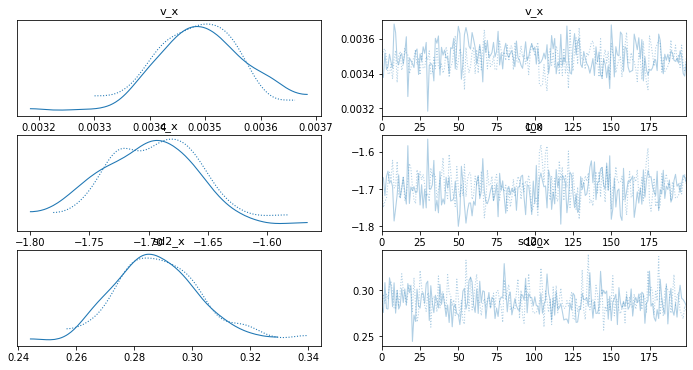

In [241]:
# 4: run MCMC

with model:
    step = pm.NUTS()
    trace = pm.sample(2000, 
                      step = [step], 
                      cores=2, 
                      return_inferencedata=False)
    
# quickly show posteriors for each parameter as a sanity check
with model:
    _ = az.plot_trace(trace[1000:][::5])

Text(0, 0.5, 'P(velocity of x)')

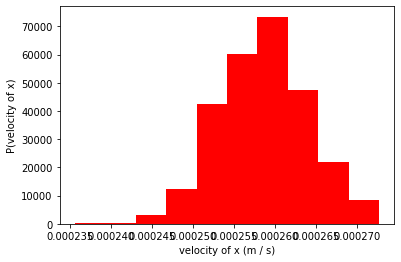

In [242]:
# 5: show posterior of velocity in x direction; "undo" zscoring to 
# make these values more interpretable (i.e. multiply MCMC posterior 
# distribution over velocity by the standard deviation of the raw x
# position (red_x_sd))

fig = plt.figure()
ax = fig.add_subplot()

ax.hist(red_x_sd * trace["v_x"][1000:][::5], 
        density=True,
        label="red x velocity",
        color="r")

ax.set_xlabel("velocity of x (m / s)")
ax.set_ylabel("P(velocity of x)")


Text(0, 0.5, 'x position (m)')

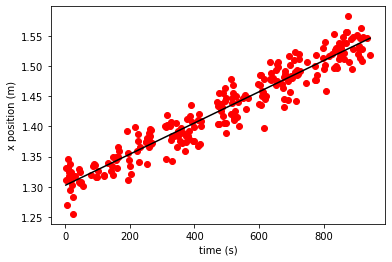

In [243]:
# 6: let's check if this is sensible with the original data...

# use median of posterior for each param
med_v = np.median(red_x_sd * trace["v_x"][1000:][::5]) # get median
med_c = np.median(trace["c_x"][1000:][::5])

fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(t, red_x, c="r")
x_offset = med_c * red_x_sd + red_x_mu
ax.plot(t[[0, -1]], med_v * t[[0, -1]] + x_offset, c="k")

ax.set_xlabel("time (s)")
ax.set_ylabel("x position (m)")


Looks good! Now let's write a function that will perform this procedure for the observed x and y positions for both the red and blue object.

In [248]:
def get_MCMC_velocity(observed_t, observed_x):
    """
    From observed positions (in 1D) and times, use MCMC to estimate 
    the posterior of the velocity.
    
    Parameters
    ----------
    observed_t : np vector
        observed sample times 
    
    observed_x : np vecotr
        observed locations
    
    
    Returns
    -------
    velocity_dist : np vector
        histogram over this vector approximates the velocity posterior
        
    """
    # (1: pull out observed time vector -- already done!)

    # 2: zscore observed location
    x_mu = observed_x.mean()
    x_sd = observed_x.std()
    
    x_norm = (observed_x - x_mu) / x_sd
    
    # 3: define model with pymc3
    with pm.Model() as model:
    
        # define uniform priors
        v = pm.Uniform('v', -0.005, 0.005) # velocity in x direction
        c = pm.Uniform('c', -5, 5) # constant offset in x direction
        sd2 = pm.Uniform('sd2', 0, 5) # variance of gauss error in x direction
   
        # define distribution over observations of x
        X = pm.Normal("X", v * observed_t + c, sd2, observed=x_norm)
        
    # 4: run MCMC
    with model:
        step = pm.NUTS()
        trace = pm.sample(2000, 
                          step = [step], 
                          cores=2, 
                          return_inferencedata=False)
        
    # 5: return velocity posterior; "undo" zscoring of x
    velocity_dist = x_sd * trace["v"][1000:][::5]
    return velocity_dist


In [251]:
V_red_x = get_MCMC_velocity(t, np.array(data["red_pos_X"]))
V_red_y = get_MCMC_velocity(t, np.array(data["red_pos_Y"]))
                            
V_blue_x = get_MCMC_velocity(t, np.array(data["blue_pos_X"]))
V_blue_y = get_MCMC_velocity(t, np.array(data["blue_pos_Y"]))


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd2, c, v]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 16 seconds.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd2, c, v]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8792124898968738, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd2, c, v]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 16 seconds.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd2, c, v]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 18 seconds.


Text(0, 0.5, 'P(blue speed)')

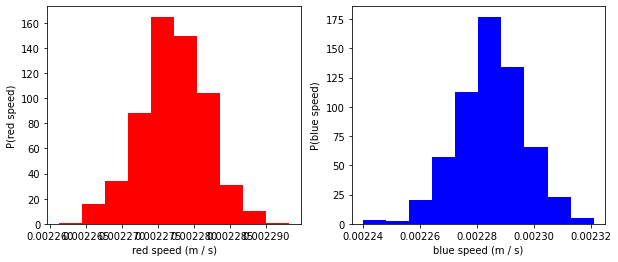

In [256]:
fig = plt.figure(figsize=(10, 4))

ax_r = fig.add_subplot(1, 2, 1)
red_speed = np.sqrt(V_red_x ** 2 + V_red_y ** 2)
ax_r.hist(red_speed, color="r")
ax_r.set_xlabel("red speed (m / s)")
ax_r.set_ylabel("P(red speed)")

ax_b = fig.add_subplot(1, 2, 2)
blue_speed = np.sqrt(V_blue_x ** 2 + V_blue_y ** 2)
ax_b.hist(blue_speed, color="b")
ax_b.set_xlabel("blue speed (m / s)")
ax_b.set_ylabel("P(blue speed)")


### b) confidence intervals

### c) same speed

### d) reduced data set